## DEMAND FORECASTING

![image.png](attachment:image.png)

<b>Demand Forecasting is the process in which historical sales data is used to develop an estimate of an expected forecast of customer demand. To businesses, Demand Forecasting provides an estimate of the amount of goods and services that its customers will purchase in the foreseeable future.</i>

# 1.0 Import Library

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import lightgbm as lgb
plt.style.use('ggplot')
seed = 433
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 1.2 Load the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
train_df = pd.read_csv('/content/drive/My Drive/Dataset/train.csv')
# First let us load the datasets into different Dataframes
#train_df = pd.read_csv('train.csv')

# Dimensions
print('Train shape:', train_df.shape)
# Set of features we have are: date, store, and item
display(train_df.sample(10))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Train shape: (913000, 4)


,date,store,item,sales
85047,2015-11-18,7,5,9
36390,2017-08-24,10,2,96
169852,2013-02-04,4,10,30
58034,2016-11-29,2,4,35
744273,2015-12-28,8,41,21
620385,2016-10-03,10,34,25
623369,2014-12-05,2,35,62
749914,2016-06-08,1,42,45
53779,2015-04-06,10,3,31
234632,2015-06-24,9,13,109


In [ ]:
#import os
#os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
#pd.read_csv('/content/drive/My Drive/Dataset/train.csv')
train = pd.read_csv('/content/drive/My Drive/Dataset/train.csv',parse_dates=[0],nrows=None)
test = pd.read_csv('/content/drive/My Drive/Dataset/test.csv',parse_dates=[1], nrows=None )
print('Number of rows and columns in train dataset are:',train.shape)
print('Number of rows and columns in test dataset are:', test.shape)

Number of rows and columns in train dataset are: (913000, 4)
Number of rows and columns in test dataset are: (45000, 4)


### 1.3 Useful function

In [ ]:
def basic_details(df):
    """Find number of missing value,dtyeps, unique value in 
    dataset"""
    k = pd.DataFrame()
    k['Missing value'] = df.isnull().sum()
    k['% Missing value'] = df.isnull().sum()/df.shape[0]
    k['dtype'] = df.dtypes
    k['N unique'] = df.nunique()
    return k

In [ ]:
def agg_stats(df,statistics,groupby_column):
    """Aggregate a column by unit sales statistics such as 
    'mean','sum','min','max', 'var', 'std',"""
    f,ax = plt.subplots(3,2,figsize=(14,8))
    ax =ax.ravel()
    for i,s in enumerate(statistics):
        tmp = (df
         .groupby(groupby_column)
         .agg({'sales':s})
         )
        tmp.columns = ['sales_{}'.format(s)]
        sns.lineplot(x=tmp.index, y = tmp.iloc[:,0],color='blue',ax=ax[i])
        ax[i].set_xticks(tmp.index)
        for ticks in ax[i].get_xticklabels(): ticks.set_rotation(90)
        #plt.xticks(rotation=90)
        ax[i].set_title('sales_{}'.format(s))
        ax[i].set_ylabel('')
    plt.tight_layout()

In [ ]:
### date_time_feat
def date_time_feat(df,column):
    "Extract date time feature"
    df['day'] = df[column].dt.day
    df['dayofweek'] = df[column].dt.dayofweek
    df['month'] = df[column].dt.month
    df['year'] = df[column].dt.year
    
    df['is_month_end'] = df[column].dt.is_month_end.astype('int8')
    df['is_month_start'] = df[column].dt.is_month_start.astype('int8')
    df['weekofyear'] = df[column].dt.weekofyear
    # conver to category
    #df['dayofweek'] = pd.Categorical(df['dayofweek'],
     #       categories=['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday',])


In [ ]:
# Reduce memory of dataset
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe """
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

## 2.0 Exploratory data analysis
Glimpse dataset

In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


The test dataset contains id column but train dataset does not contains id column. While importing dataset parse_date is assigned with perticular column index.

In [ ]:
basic_details(test) # test dataset

,Missing value,% Missing value,dtype,N unique
id,0,0.0,int64,45000
date,0,0.0,datetime64[ns],90
store,0,0.0,int64,10
item,0,0.0,int64,50


In [ ]:
train.describe() # descriptive statistics about features

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


There are 50 diffirent item in 10 diffirent stores. The maximum number of items sold is 231 and average item sold is 52.25.

### 2.1 Date
Let's extract day, week, month, year from date feature

In [ ]:
print('Time series start time: "{}" and end time: "{}"'.format(train['date'].min(), train['date'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test['date'].min(), test['date'].max()))

Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"


In [ ]:
# Generate date time feature
date_time_feat(train,'date')
date_time_feat(test,'date')
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,date,store,item,sales,day,dayofweek,month,year,is_month_end,is_month_start,weekofyear
0,2013-01-01,1,1,13,1,1,1,2013,0,1,1
1,2013-01-02,1,1,11,2,2,1,2013,0,0,1
2,2013-01-03,1,1,14,3,3,1,2013,0,0,1
3,2013-01-04,1,1,13,4,4,1,2013,0,0,1
4,2013-01-05,1,1,10,5,5,1,2013,0,0,1


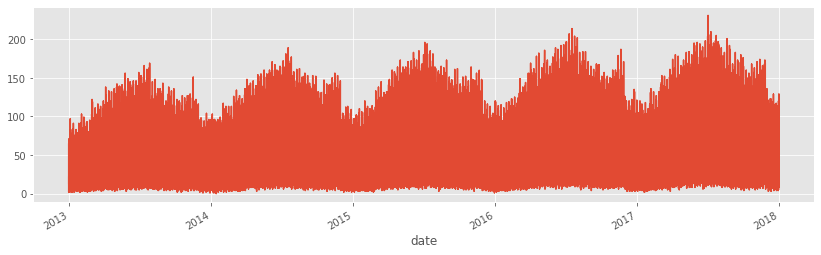

In [ ]:
plt.figure(figsize=(14,4))
train.set_index('date')['sales'].plot(kind='line')

### 2.1 Sales

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



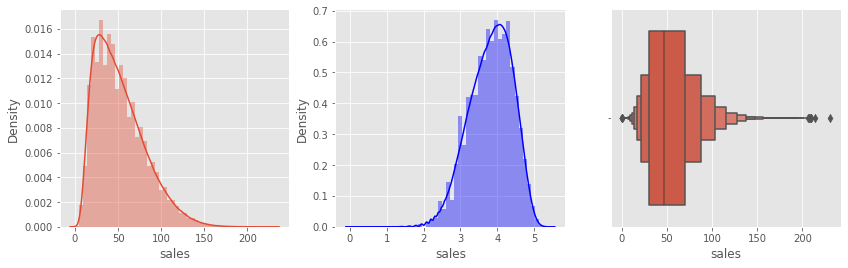

In [ ]:
f,ax = plt.subplots(1,3,figsize=(14,4))
sns.distplot(train['sales'],ax =ax[0])
sns.distplot(np.log(train['sales']+1),ax=ax[1], color='b')
sns.boxenplot(train['sales'],ax =ax[2])

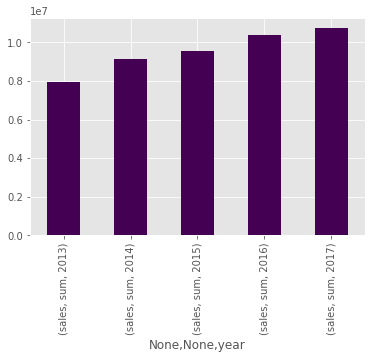

In [ ]:
(train
 .groupby(['year',])
 .agg({'sales':['sum',]})
 .unstack()
 .plot(kind='bar',cmap='viridis'))

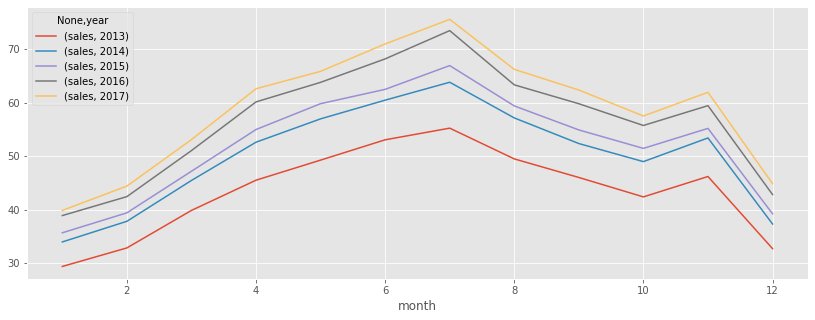

In [ ]:
(train
 .groupby(['month','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

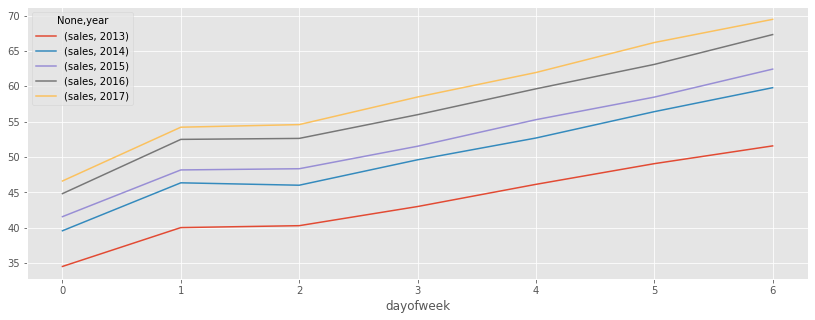

In [ ]:
(train
 .groupby(['dayofweek','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

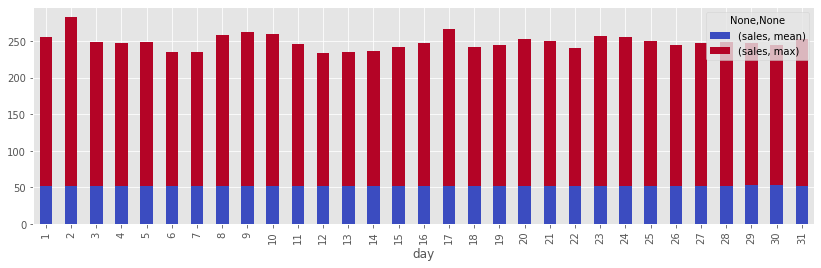

In [ ]:
(train
.groupby(['day'])
.agg({'sales':['mean','max']})
.plot(figsize=(14,4),kind='bar',stacked=True,cmap='coolwarm'))

### 2.2 Aggregate sales statistics by day

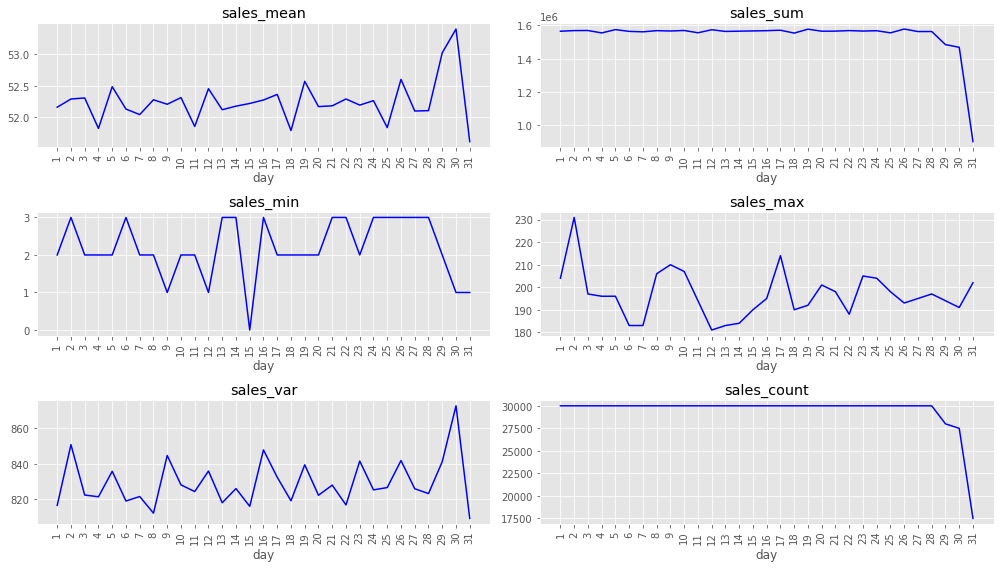

In [ ]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['day'])

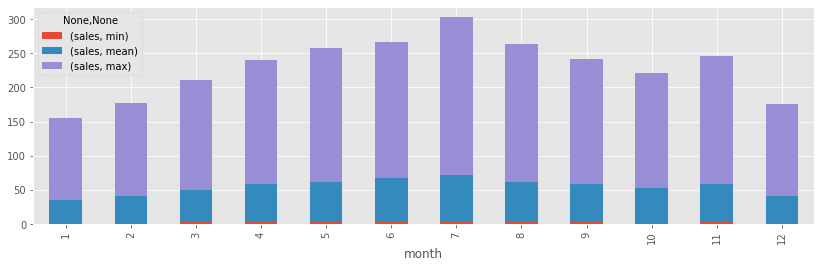

In [ ]:
(train.groupby('month')
.agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True))

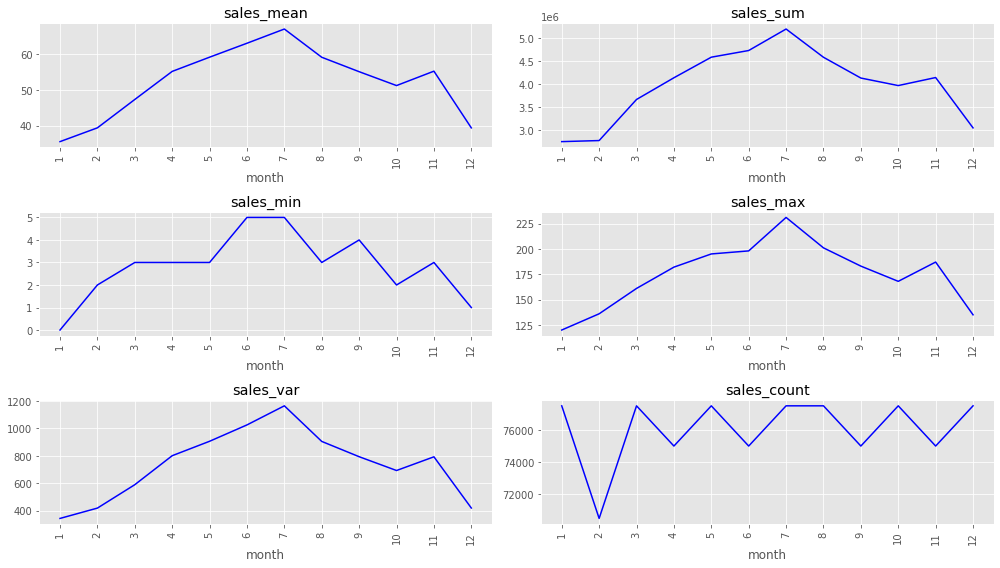

In [ ]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['month'])

### 2.3 Store

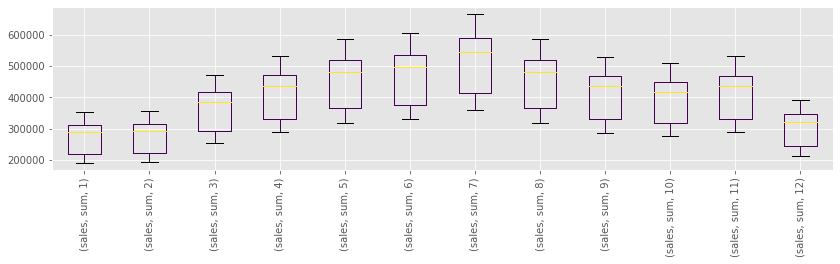

In [ ]:
(train
 .groupby(['store','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

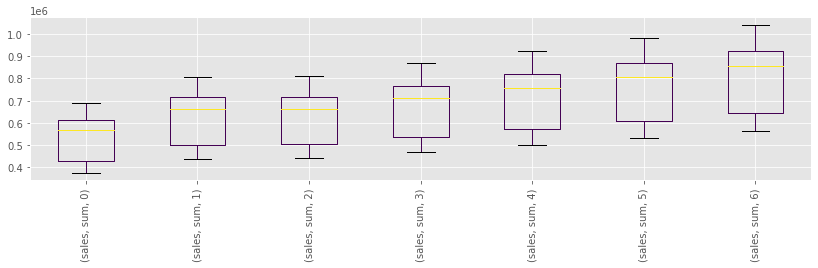

In [ ]:
(train
 .groupby(['store','dayofweek'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

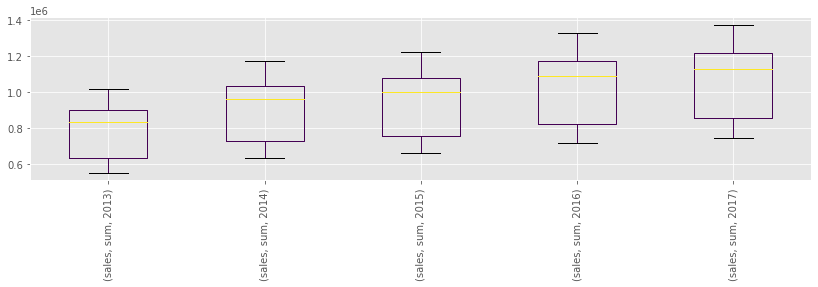

In [ ]:
(train
 .groupby(['store','year'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

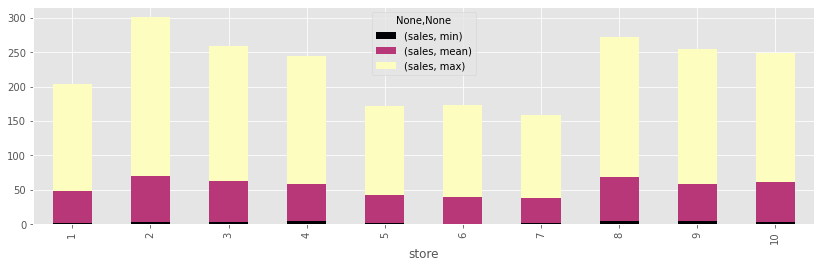

In [ ]:
(train
 .groupby('store')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='magma'))

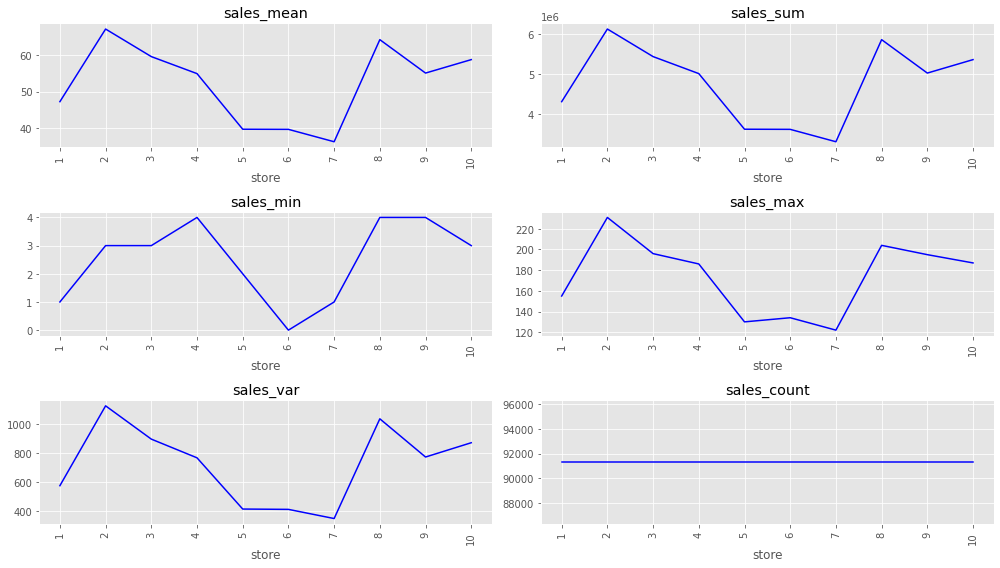

In [ ]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['store'])

### 2.4 item

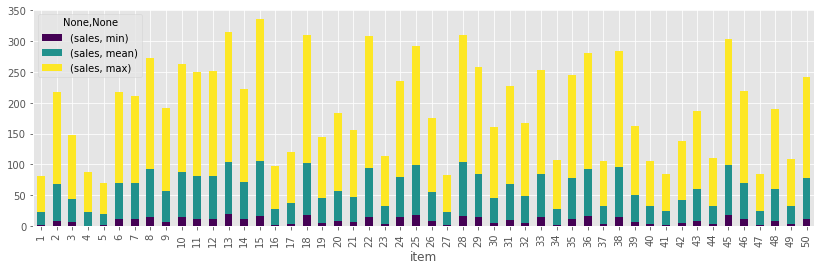

In [ ]:
(train
 .groupby('item')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='viridis'))

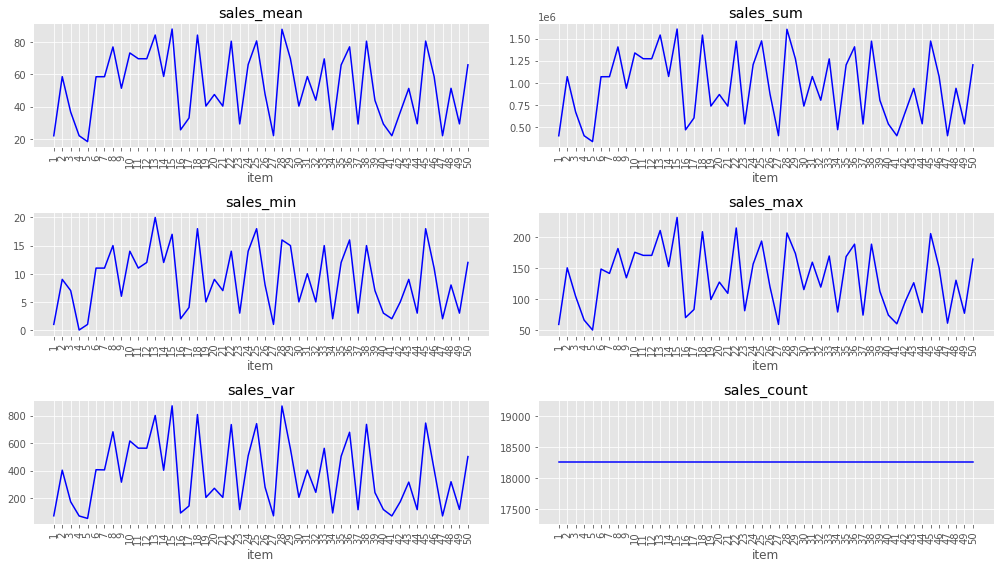

In [ ]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['item'])

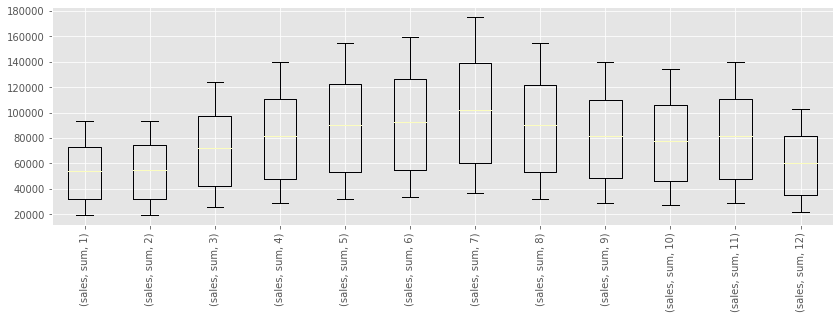

In [ ]:
(train
 .groupby(['item','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='magma'))
plt.xticks(rotation=90);

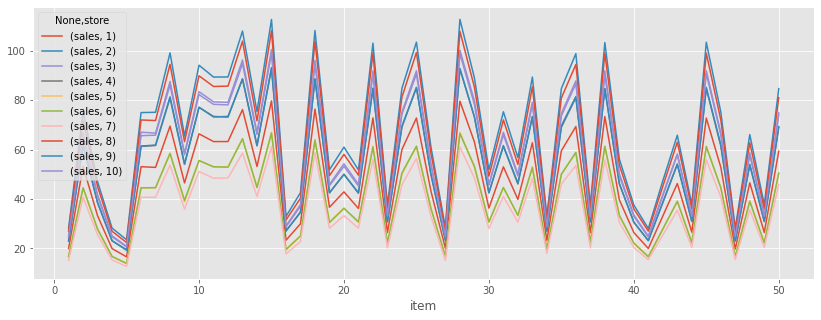

In [ ]:
(train
 .groupby(['item','store'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5),kind='line'))
plt.savefig('agg.png')

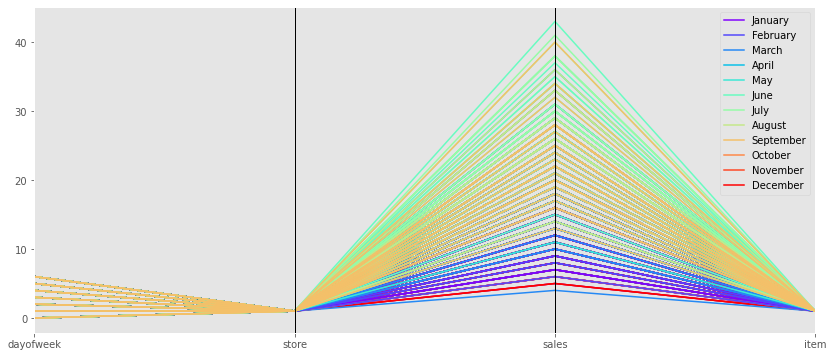

In [ ]:
train1 =train.copy()
train1['month'] = train1['date'].dt.month_name()
plt.figure(figsize=(14,6))
pd.plotting.parallel_coordinates(train1[['dayofweek','store','sales','item','month']][:1000]
                                 ,'month',colormap='rainbow')
del train1

### 2.5 Rolling window

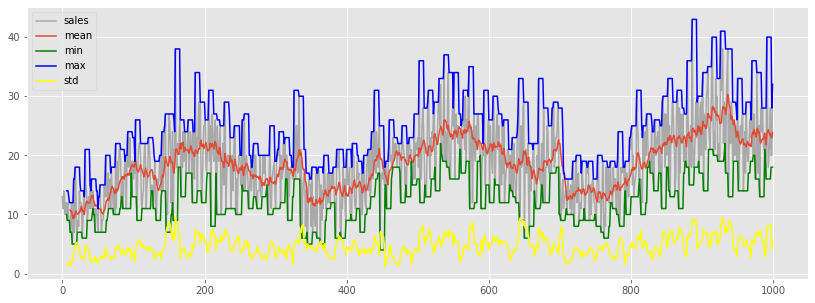

In [ ]:
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).rolling(window=12).mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='std',color='yellow')
plt.legend()
#plt.savefig('Rolling window.png')

### 2.6 Expanding window

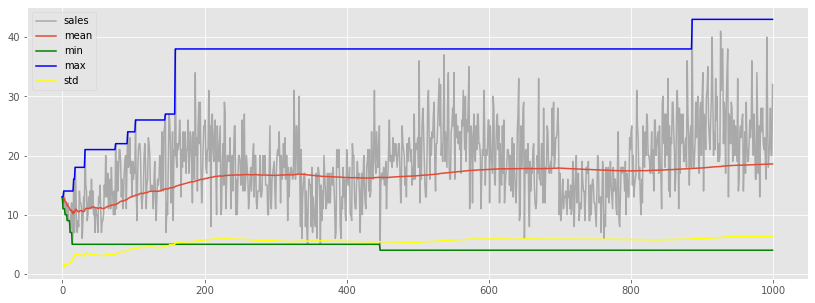

In [ ]:
# Expanding window
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).expanding().mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).expanding().min().plot(label='min',color='g')
train['sales'].head(1000).expanding().max().plot(label='max',color='b')
train['sales'].head(1000).expanding().std().plot(label='std',color='yellow')
plt.legend()

## 3.0 Data preprocessing

### 3.0 Aggregate / Rolling function

In [ ]:
# Claculate groupby statics for lag date 
def calc_stats(df, end,window,groupby=None,aggregates='mean',value='sales'):
    
    # dates
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days= window)
    # Aggregate
    df1 = df[(df.date >=first_date) & (df.date<= last_date) ]
    df_agg = df1.groupby(groupby)[value].agg(aggregates)
    # Change name of columns
    df_agg.name =  str(end).split(' ')[0]+'_' + '_'.join(groupby)+'_'+aggregates+'_'+ str(window)
    return df_agg.reset_index()

#sales_by_store_item
def sales_by_store_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item')
    data = calc_stats(df,end, window=1,aggregates=aggregates, 
                      groupby=['store','item'], value=value)
    print('window 1 added')
    
    for window in  [3,7,14,28,90,180,365]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales by store item dayofweek
def sales_by_store_item_dayofweek(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item dayofweek')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['store','item','dayofweek'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2,28*3,28*6,28*12]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item','dayofweek'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales_by_store_item_day
def sales_by_store_item_day(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item day')
    data = calc_stats(df,end, window=365, aggregates=aggregates,
                      groupby = ['store','item','day'], value=value)
    print('window 365 added')
    
    return data

# Sales by item
def sales_by_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by item ')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['item'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

In [ ]:
def calc_roll_stat(df,end,groupby=None,window=1,aggregate='mean'):
    # Rolling statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date']+groupby)['sales'].unstack().unstack()
    dfPivot = dfPivot.rolling(window=window).mean().fillna(method='bfill')
    return dfPivot.stack().stack().rename(aggregate+str(window))

def calc_expand_stat(df,end,window=1,aggregate='mean'):
    # Expanding statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date','store','item'])['sales'].unstack().unstack()
    dfPivot = dfPivot.expanding(min_periods=window).mean().fillna(method='bfill')
    dfPivot = dfPivot.stack().stack().rename(aggregate+'_'+str(window)).reset_index()
    return dfPivot

def sales_by_store_item_expading(df,end,aggregate = 'mean', value = 'sales'):
    print('Adding sales by expanding')
    data =calc_expand_stat(df,end,window=3, aggregate='mean')
    return data
# https://stackoverflow.com/questions/25917287/pandas-groupby-expanding-mean-by-column-value

In [ ]:
def create_data1(sales,test,date):
    
    # Date input
    for i in range(2):
        end = pd.to_datetime(date) - pd.Timedelta(days=7*i+1)
        print(end)
    
        # Rolling feature
        #for aggregates in ['mean','min','max','sum','std']:
        for aggregates in ['mean','sum']:

            # store/item
            print('-'*20+'Aggregate by '+aggregates+'-'*20)
            data = sales_by_store_item(sales,end, aggregates=aggregates,value='sales')
            sales = pd.merge(sales,data,on=['store','item'],how='left')
            test = pd.merge(test,data,on=['store','item'], how='left')

            # store/item/dayofweek
            df = sales_by_store_item_dayofweek(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df,)
            sales = pd.merge(sales,df,on=['store','item','dayofweek'],how='left')
            test = pd.merge(test,df,on=['store','item','dayofweek'], how='left')

            # store/item/day
            df = sales_by_store_item_day(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df)
            sales = pd.merge(sales,df,on=['store','item','day'],how='left')
            test = pd.merge(test,df,on=['store','item','day'], how='left')

            # sales/item
            df = sales_by_item(sales,end, aggregates=aggregates, value='sales')
            data = pd.merge(data,df)
            #data = pd.merge(sales,data)
            sales = pd.merge(sales,df, on=['item'],how='left')
            test = pd.merge(test,df, on=['item'], how='left')

    return sales,test

In [ ]:
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tes_start = '2018-01-01'

In [ ]:
# Rolling aggregation or lag feature for diffirend window size
train1,test1 = create_data1(train,test,tes_start)

2017-12-31 00:00:00
--------------------Aggregate by mean--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 56 added
--------------------Aggregate by sum--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 

### 3.1 One hot encoding

In [ ]:
train1['id'] = np.nan
train1['is_train'] = True
test1['is_train'] = False
test1['sales'] = np.nan

# concat train,test
train_test = pd.concat([train1,test1],axis=0)

#Log transform
train_test['sales_log'] = np.log(train_test['sales']+1)
gc.collect()
train_test.shape

def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    df = pd.get_dummies(df,drop_first=True,columns=columns)
    print('After OHE', df.shape)
    return df

In [ ]:
gc.collect()
train_test = one_hot_encoding(train_test,columns=['month','dayofweek'])

Original shape (958000, 94)
After OHE (958000, 109)


In [ ]:
reduce_memory_usage(train_test)

Intial memory usage: 676.0787963867188 MB
Memory usage after complition:  252.15911865234375 MB


In [ ]:
#plt.figure(figsize=(14,10))
#sns.heatmap(train_test1.corr(), cmap='coolwarm', annot=True,fmt='.2f')

## 4.0 Model selection

In [ ]:
# Model
col_drop = ['id','is_train','sales','sales_log']
X = train_test[train_test['is_train'] == True].drop(col_drop, axis=1)
y = train_test[train_test['is_train'] == True]['sales_log']
test_new = train_test[train_test['is_train'] == False].drop(col_drop +['date'],axis=1)

# Time series based split
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tra_start, tra_end = '2013-01-01','2016-12-31'
val_start, val_end = '2017-01-01','2017-12-31'
tes_start = '2018-01-01'

X_train = X[X.date.isin(pd.date_range(tra_start,tra_end))].drop(['date'],axis=1)
X_valid = X[X.date.isin(pd.date_range(val_start, val_end))].drop(['date'],axis=1)
y_train = y[X.date.isin(pd.date_range(tra_start,tra_end))]
y_valid = y[X.date.isin(pd.date_range(val_start, val_end))]
gc.collect()
X.shape,test_new.shape

((913000, 105), (45000, 104))

In [ ]:
# SMAPE Systematic mean absolute Persent error
def smape(y_true,y_pred):
    
    n = len(y_pred)
    masked_arr = ~((y_pred==0)&(y_true==0))
    y_pred, y_true = y_pred[masked_arr], y_true[masked_arr]
    nom = np.abs(y_true - y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    smape = 200/n * np.sum(nom/denom)
    return smape
def lgb_smape(pred,train_data):
    ''' 
    Custom evaluvation function
    '''
    label = train_data.get_label()
    smape_val = smape(np.expm1(pred), np.expm1(label))
    return 'SMAPE',smape_val, False

In [ ]:
import sklearn
from sklearn.metrics import r2_score
def rscore(y_true,y_pred):
    return sklearn.metrics.r2_score(y_true, y_pred)
    
def lgb_rscore(pred,train_data):
    ''' 
    Custom evaluvation function
    '''
    label = train_data.get_label()
    rscore_val = rscore(np.expm1(pred), np.expm1(label))
    return 'RSCORE',rscore_val, False

In [ ]:
import sklearn
from sklearn.metrics import r2_score

## 5.0 Models

# a) Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)
predict1 = model1.predict(X_valid)

In [ ]:
y_pred_new=test_predict = model1.predict(test_new)
y_pred = model1.predict(X_valid)
print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))

rscore is 0.6558538493142778


# b) XGBoost 

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
#from sklearn.preprocessing import Imputer


#define model 
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)
# make predictions
predictions = my_model.predict(X_valid)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_valid)))

[11:25:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 0.12240535


In [ ]:
y_pred_new=test_predict = my_model.predict(test_new)
y_pred = my_model.predict(X_valid)
print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))

rscore is 0.9233099242965672


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# c) Decision Tree Regressor¶


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

dec_reg_model = DecisionTreeRegressor(random_state=1)
dec_reg_model.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [ ]:
predictions = dec_reg_model.predict(X_valid)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_valid)))

Mean Absolute Error : 0.1710087944488003


In [ ]:
## prediction on test data spliting of metadata
x_pred_dec = dec_reg_model.predict(X_valid)
print("Mean Squared Log Error is ", mean_squared_log_error(predictions,y_valid))

Mean Squared Log Error is  0.002518574556977172


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_valid,predictions)**(0.5))

Root Mean Squared Error is  0.22365719975270779


In [ ]:
y_pred_new=test_predict = dec_reg_model.predict(test_new)
y_pred = dec_reg_model.predict(X_valid)
print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))

rscore is 0.8446189984842214


# d) Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
##RandomForest Regressor
ran_reg_model = RandomForestRegressor(random_state=1)
ran_reg_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
redictions = ran_reg_model.predict(X_valid)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_valid)))

Mean Absolute Error : 0.1710087944488003


In [ ]:
## prediction on test data spliting of metadata
x_pred_dec = ran_reg_model.predict(X_valid)
print("Mean Squared Log Error is ", mean_squared_log_error(predictions,y_valid))

Mean Squared Log Error is  0.002518574556977172


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_valid,predictions)**(0.5))

Root Mean Squared Error is  0.22365719975270779


In [ ]:
y_pred_new=test_predict = ran_reg_model.predict(test_new)
y_pred = ran_reg_model.predict(X_valid)
print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))

rscore is 0.9092196878110362


# b) Time Series Analysis 

## Distribution of sales
Now let us understand how the sales varies across all the items in all the stores

In [ ]:
# Sales distribution across the train data
sales_df = train_df.copy(deep=True)
sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
print('Max sale:', sales_df.sales.max())
print('Min sale:', sales_df.sales.min())
print('Avg sale:', sales_df.
sales.mean())
print()

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

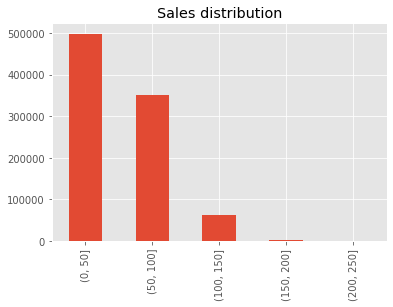

In [ ]:
# Let us visualize the same
pd.value_counts(sales_df.sales_bins).plot(kind='bar', title='Sales distribution');

As we can see, almost 92% of sales are less than 100. Max, min and average sales are 231, 0 and 52.25 respectively.   
So any prediction model has to deal with the skewness in the data appropriately. 

## How does sales vary across stores
Let us get a overview of sales distribution in the whole data.

In [ ]:
# Let us understand the sales data distribution across the stores
store_df = train_df.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
# Pivoted dataframe
display(sales_pivoted_df)

sales                        ...                                 
item          1          2          3   ...         48         49         50
store                                   ...                                 
1      19.971522  53.148959  33.208105  ...  46.546002  26.461665  59.342826
2      28.173604  75.316539  46.992333  ...  66.028478  37.711939  84.622125
3      25.070099  66.804491  41.771084  ...  58.700986  33.259584  74.958379
4      22.938664  61.715225  38.548193  ...  53.765608  30.840635  68.921687
5      16.739321  44.488499  27.835706  ...  39.281490  22.371851  50.319277
6      16.717963  44.533954  27.811062  ...  39.052574  22.181271  50.516429
7      15.159365  40.717963  25.531216  ...  35.624315  20.406353  45.823658
8      26.983571  71.656627  45.076123  ...  62.737130  36.035049  80.972070
9      23.325849  61.792442  38.535049  ...  53.976999  31.052574  69.308324
10     24.736035  65.566813  41.113363  ...  57.814896  33.032311  74.037240

[10 rows x 50 columns]

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!

In [ ]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [ ]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

From the visualization, it is clear that the stores with ID 2 and 8 have higher average sales than the remaining stores and is a clear indication that they are doing good money!

Whereas store with ID 7 has very poor performance in terms of average sales.

## How does sales vary across items

In [ ]:
# Let us calculate the average sales of each of the item across all the stores
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
# And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
# Display the top 10 rows
display(avg_sales_per_item_across_stores_df.head())

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


Great! Let us visualize these average sales per item!

In [ ]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

Amazing! The sales is uniformly distributed across all the items.   
Top items with highest average sale are 15, 28, 13, 18 and with least average sales are 5, 1, 41 and so on.

## Time-series visualization of the sales
Let us see how sales of a given item in a given store varies in a span of 5 years.

In [ ]:
store_item_df = train_df.copy()
# First, let us filterout the required data
store_id = 10   # Some store
item_id = 40    # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.store == store_id]
store_item_df = store_item_df[store_item_df.item == item_id]
print('After filter:', store_item_df.shape)
#display(store_item_df.head())

# Let us plot this now
store_item_ts_data = [go.Scatter(
    x=store_item_df.date,
    y=store_item_df.sales)]
py.iplot(store_item_ts_data)

Before filter: (913000, 4)
After filter: (1826, 4)


Woww! Clearly there is a pattern here! Feel free to play around with different store and item IDs.   
Almost all the items and store combination has this pattern!

The sales go high in June, July and August months. The sales will be lowest in December, January and February months. That's something!!

Let us make it more interesting. What if we aggregate the sales on a montly basis and compare different items and stores.   
This should help us understand how different item sales behave at a high level.

In [ ]:
multi_store_item_df = train_df.copy()
# First, let us filterout the required data
store_ids = [1, 1, 1, 1]   # Some stores
item_ids = [10, 20, 30, 40]    # Some items
print('Before filter:', multi_store_item_df.shape)
multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales

# Let us plot this now
multi_store_item_ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = multi_store_item_df[multi_store_item_df.store == st]
    flt = flt[flt.item == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(multi_store_item_ts_data)

Before filter: (913000, 4)
After filter: (7304, 4)


Interesting!!   
Though the pattern remains same across different stores and items combinations, the **actual sale value consitently varies with the same scale**. 

As we can see in the visualization, item 10 has consistently highest sales through out the span of 5 years!   
This is an interesting behaviour that can be seen across almost all the items. 



In [ ]:
test_new

,store,item,day,year,is_month_end,is_month_start,weekofyear,2017-12-31_store_item_mean_1,2017-12-31_store_item_mean_3,2017-12-31_store_item_mean_7,2017-12-31_store_item_mean_14,2017-12-31_store_item_mean_28,2017-12-31_store_item_mean_90,2017-12-31_store_item_mean_180,2017-12-31_store_item_mean_365,2017-12-31_store_item_dayofweek_mean_7,2017-12-31_store_item_dayofweek_mean_14,2017-12-31_store_item_dayofweek_mean_28,2017-12-31_store_item_dayofweek_mean_56,2017-12-31_store_item_dayofweek_mean_84,2017-12-31_store_item_dayofweek_mean_168,2017-12-31_store_item_dayofweek_mean_336,2017-12-31_store_item_day_mean_365,2017-12-31_item_mean_7,2017-12-31_item_mean_14,2017-12-31_item_mean_28,2017-12-31_item_mean_56,2017-12-31_store_item_sum_1,2017-12-31_store_item_sum_3,2017-12-31_store_item_sum_7,2017-12-31_store_item_sum_14,2017-12-31_store_item_sum_28,2017-12-31_store_item_sum_90,2017-12-31_store_item_sum_180,2017-12-31_store_item_sum_365,2017-12-31_store_item_dayofweek_sum_7,2017-12-31_store_item_dayofweek_sum_14,2017-12-31_store_item_dayofweek_sum_28,2017-12-31_store_item_dayofweek_sum_56,2017-12-31_store_item_dayofweek_sum_84,...,2017-12-24_item_mean_14,2017-12-24_item_mean_28,2017-12-24_item_mean_56,2017-12-24_store_item_sum_1,2017-12-24_store_item_sum_3,2017-12-24_store_item_sum_7,2017-12-24_store_item_sum_14,2017-12-24_store_item_sum_28,2017-12-24_store_item_sum_90,2017-12-24_store_item_sum_180,2017-12-24_store_item_sum_365,2017-12-24_store_item_dayofweek_sum_7,2017-12-24_store_item_dayofweek_sum_14,2017-12-24_store_item_dayofweek_sum_28,2017-12-24_store_item_dayofweek_sum_56,2017-12-24_store_item_dayofweek_sum_84,2017-12-24_store_item_dayofweek_sum_168,2017-12-24_store_item_dayofweek_sum_336,2017-12-24_store_item_day_sum_365,2017-12-24_item_sum_7,2017-12-24_item_sum_14,2017-12-24_item_sum_28,2017-12-24_item_sum_56,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,1,1,1,2018,0,1,1,27,20.333334,17.571428,15.928572,16.964285,20.188889,23.077778,22.158905,13,16.0,14.75,16.125,16.583334,17.666666,17.333334,21.916666,18.714285,18.392857,18.478571,21.775000,27,61,123,223,475,1817,4154,8088,13,32,59,129,199,...,18.385714,19.575001,22.582144,18,36,100,215,478,1855,4256,8085,19,39,56,138,198,427,828,263,1265,2574,5481,12646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,2,2018,0,0,1,27,20.333334,17.571428,15.928572,16.964285,20.188889,23.077778,22.158905,16,11.5,14.00,17.250,18.750000,20.291666,20.333334,21.166666,18.714285,18.392857,18.478571,21.775000,27,61,123,223,475,1817,4154,8088,16,23,56,138,225,...,18.385714,19.575001,22.582144,18,36,100,215,478,1855,4256,8085,7,20,54,146,227,494,978,254,1265,2574,5481,12646,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,3,2018,0,0,1,27,20.333334,17.571428,15.928572,16.964285,20.188889,23.077778,22.158905,14,15.0,16.00,19.000,18.250000,20.375000,21.416666,22.583334,18.714285,18.392857,18.478571,21.775000,27,61,123,223,475,1817,4154,8088,14,30,64,152,219,...,18.385714,19.575001,22.582144,18,36,100,215,478,1855,4256,8085,16,33,78,154,220,504,1028,271,1265,2574,5481,12646,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,4,2018,0,0,1,27,20.333334,17.571428,15.928572,16.964285,20.188889,23.077778,22.158905,19,15.5,15.75,18.250,20.416666,23.041666,23.083334,19.916666,18.714285,18.392857,18.478571,21.775000,27,61,123,223,475,1817,4154,8088,19,31,63,146,245,...,18.385714,19.575001,22.582144,18,36,100,215,478,1855,4256,8085,12,26,59,148,246,556,1102,239,1265,2574,5481,12646,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,5,2018,0,0,1,27,20.333334,17.571428,15.928572,16.964285,20.188889,23.077778,22.158905,15,10.5,13.50,17.375,18.500000,23.291666,23.250000,23.500000,18.714285,18.392857,18.478571,21.775000,27,61,123,223,475,1817,4154,8088,15,21,54,139,222,...,18.385714,19.575001,22.582144,18,36,100,215,478,1855,4256,8085,6,22,58,142,226,582,1111,282,1265,2574,5481,12646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,.

## 5.0 Model

In [ ]:
def lgb_model(X_train, X_valid, y_valid, y_test,test_new):
    lgb_param = {}
    lgb_param['boosting_type'] ='gbdt'
    lgb_param['max_depth'] = 7
    lgb_param['num_leaves'] = 2**7
    lgb_param['learning_rate'] = 0.05
    #lgb_param['n_estimators'] = 3000
    lgb_param['feature_fraction'] = 0.9
    lgb_param['bagging_fraction'] = 0.9
    lgb_param['lambda_l1'] = 0.06
    lgb_param['lambda_l2'] =  0.1
    lgb_param['random_state'] = seed
    lgb_param['n_jobs'] = 4
    lgb_param['silent'] = -1
    lgb_param['verbose'] = -1
    lgb_param['metric'] = 'mae'
    
    model = lgb.LGBMRegressor(**lgb_param)
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_valid = lgb.Dataset(X_valid,y_valid)
    valid_set = [lgb_train,lgb_valid]
    #model = lgb.train(params=lgb_param,train_set=lgb_train,valid_sets=valid_set,num_boost_round= 300,
    #                  feval=lgb_rscore,early_stopping_rounds=20,)
    model = lgb.train(params=lgb_param,train_set=lgb_train,valid_sets=valid_set,num_boost_round= 300,
                      feval=lgb_smape,early_stopping_rounds=20,)
    print('-'*10,'*'*20,'-'*10)
    #model.fit(X_train,y_train, eval_set= [(X_train,y_train),(X_valid,y_valid)],
    #          eval_metric ='rmse',early_stopping_rounds=20,verbose=100)
    
    y_pred = model.predict(X_valid)
    print('Root mean_squared_error','-'*20 ,np.sqrt(mean_squared_error(y_valid, y_pred)))
    print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))
    y_pred_new = model.predict(test_new)
    #print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred_new))
    return y_pred_new, model

In [ ]:
# Model training
y_pred_new, model = lgb_model(X_train, X_valid, y_valid, y_valid,test_new)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



[1]	training's l1: 0.449862	training's SMAPE: 44.0816	valid_1's l1: 0.467346	valid_1's SMAPE: 45.697
Training until validation scores don't improve for 20 rounds.
[2]	training's l1: 0.429565	training's SMAPE: 42.2474	valid_1's l1: 0.447381	valid_1's SMAPE: 43.8937
[3]	training's l1: 0.410545	training's SMAPE: 40.5112	valid_1's l1: 0.428788	valid_1's SMAPE: 42.2004
[4]	training's l1: 0.393274	training's SMAPE: 38.9201	valid_1's l1: 0.411537	valid_1's SMAPE: 40.6123
[5]	training's l1: 0.376008	training's SMAPE: 37.318	valid_1's l1: 0.394522	valid_1's SMAPE: 39.0348
[6]	training's l1: 0.359659	training's SMAPE: 35.7897	valid_1's l1: 0.378467	valid_1's SMAPE: 37.5354
[7]	training's l1: 0.344291	training's SMAPE: 34.344	valid_1's l1: 0.363504	valid_1's SMAPE: 36.1307
[8]	training's l1: 0.329895	training's SMAPE: 32.9808	valid_1's l1: 0.349613	valid_1's SMAPE: 34.8196
[9]	training's l1: 0.316127	training's SMAPE: 31.6697	valid_1's l1: 0.335727	valid_1's SMAPE: 33.5
[10]	training's l1: 0.3030

### 6.0 Model evaluation

In [ ]:
#print('Root mean_squared_error',np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
#182500, 45000]

In [ ]:
#len(y_valid)
#len(X_valid)

In [ ]:
#len(X_valid)

In [ ]:
#len(test_new)

In [ ]:
#len(test1)

In [ ]:
#len(y_valid)

In [ ]:
#print(y_valid.shape)

In [ ]:
#print(y_pred_new.shape)

In [ ]:
#len(y_pred)

In [ ]:
#len(y_pred_new)#

In [ ]:
#len(X_train)

In [ ]:
#print("rscore is",sklearn.metrics.r2_score(y_valid,y_pred_new))

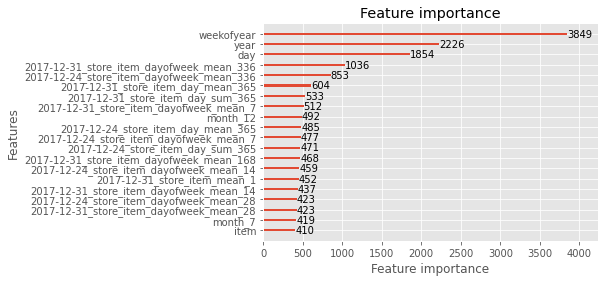

In [ ]:
# Feature importance
lgb.plot_importance(model,max_num_features=20);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



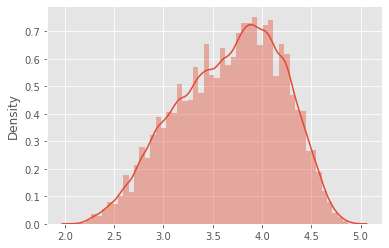

In [ ]:
sns.distplot(y_pred_new)

## END OF LGBM MODEL


In [ ]:
## 

##    ARIMA MODEL 
                                                            

Import the packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') #to ignore if any warnings takes place during the run time.
#import statsmodels.api as sm
import os
#os.chdir("/content/drive/My Drive/Dataset/Dataset")

In [ ]:
#read the data
df=pd.read_csv('/content/drive/My Drive/Dataset/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
#check for missing values in train data
df.isnull().sum()
 #No missing valuues



date     0
store    0
item     0
sales    0
dtype: int64

Here for better understanding of the data, We can eloborate as month and weekday wise.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:

# per 1 store, 1 item
train_df = df[df['store']==1]
train_df = train_df[df['item']==1]

# train_df = train_df.set_index('date')
train_df['year'] = df['date'].dt.year
train_df['month'] = df['date'].dt.month
train_df['day'] = df['date'].dt.dayofyear
train_df['weekday'] = df['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


Below plots are for checking the seasonality, trends and outliers.

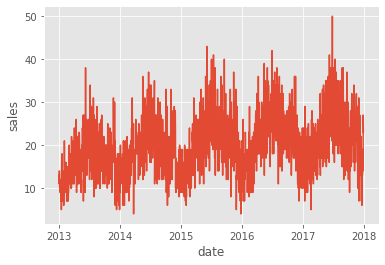

In [ ]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

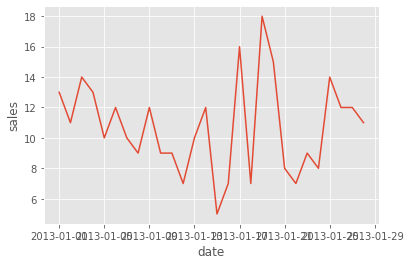

In [ ]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

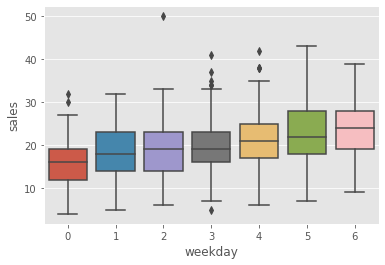

In [ ]:
sns.boxplot(x="weekday", y="sales", data=train_df)

In [ ]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


**Time series decomposition**

Think of the time series ytyt as consisting of three components: a seasonal component, a trend-cycle component (containing both trend and cycle), and a remainder component (containing anything else in the time series).
1. Additive model
1. Multiplicative model

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series.

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate.






<Figure size 432x288 with 0 Axes>

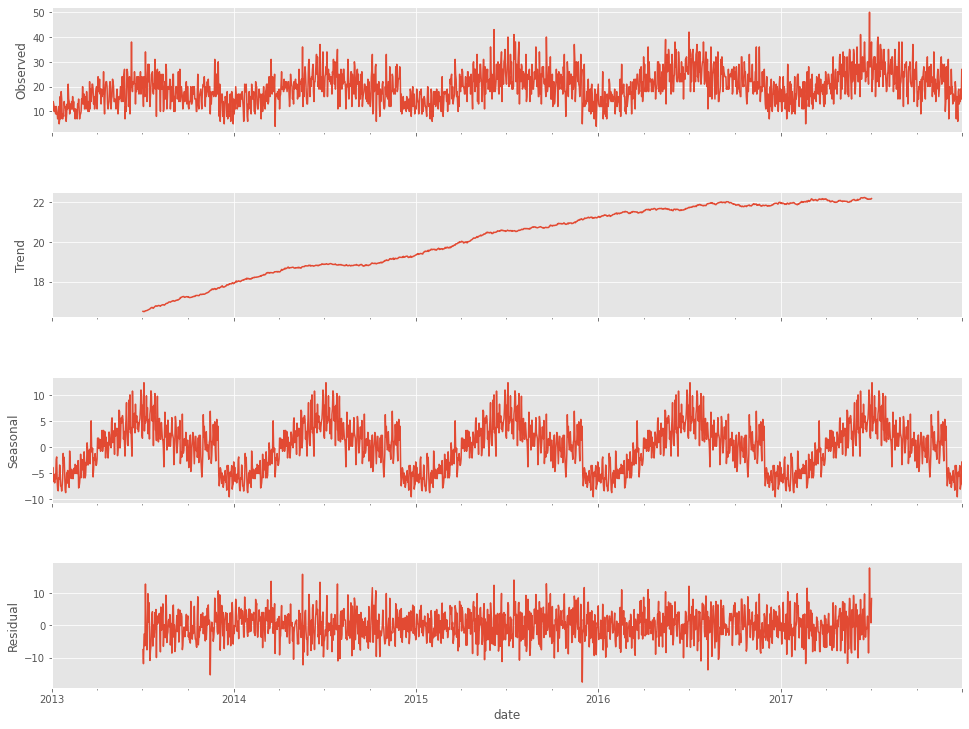

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


 The yearly pattern is very obvious. and also we can see a upwards trend. Which means this data is not stationary.



In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
   
    
    

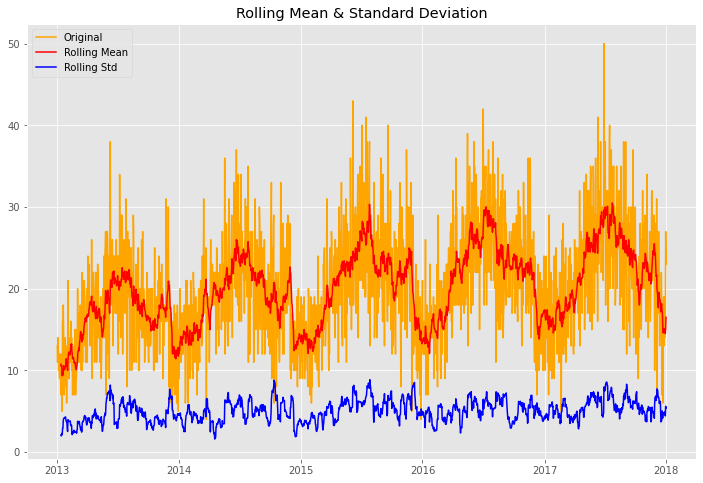

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [ ]:
test_stationarity(train_df['sales'])

**How to find whether our data is stationary or not ?**

the smaller p-value, the more likely it's stationary. Here our p-value is 0.036. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.
To get a stationary data, there's many techiniques. We can use log, differencing etc...

**NOTE**

If the **p-value** is less than 5%(significance level) or If the **Test Static** value is greater than than the **Critical value** than our data is stationary

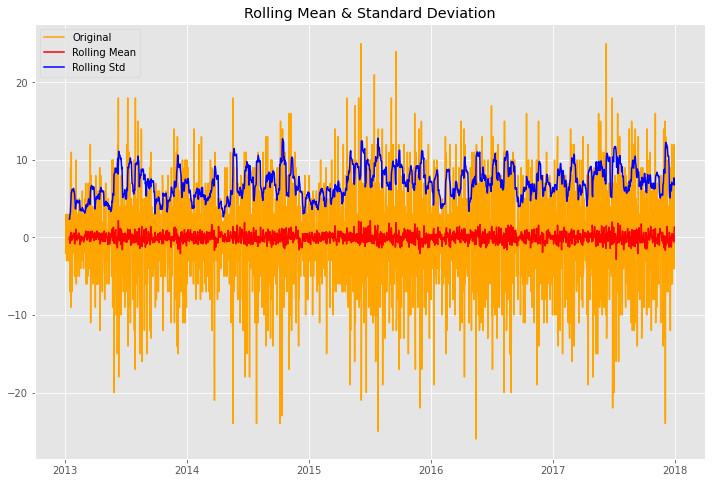

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [ ]:
#this is for reducing trend and seasonality
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

**ACF (Auto Corelation Function) and (Partial Auto Corelation Function)**

 **What is ACF ?**
 
 For Instance today stock price we predicted based on yesterday stock price the ACF will tell how much strongly they are corelated, If todays value is depended on day before yesterday than ACF will tell how strong they are and how many days required to predict the todays value.
 
 **What is PACF?**
 
 If we want to calculate the corelation between today and yesterday we have to take the corelation of day before yesterday because todays value depends upon the yesterday time spot. So this is the reason we use PACF.

  ** PACF- AR model**
   
   **ACF- MA model**
   
![image.png](attachment:image.png)

by the above images we can observe that, the lines which crosses the blue dotted lines in PACF and ACF those lines are considered to be that many days are required to predict the todays value. **For example in above PACF plot that has only three lines which crossed the blue dotted lines so last three days values are required to predict the todays value**, similarly ACF plot also but for model we should not consider ACF-MA model because many lines crossed the blue threshold line, so it will create the model complex. So we should select only PACF-AR model to predict

   ***if you want to know more about PACF and ACF go through this link***     https://www.youtube.com/watch?v=5Q5p6eVM7zM

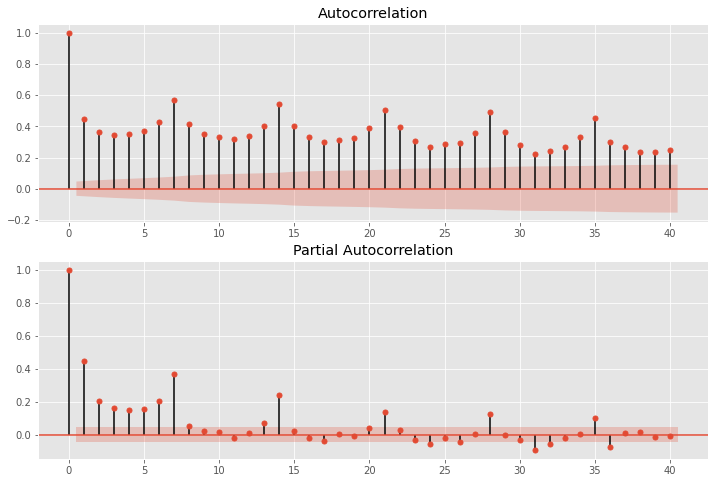

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)      #lags=40

By seeing the above plots, there are lots of significant plots so as previously i explained if more lines crossed the blue line, than the model will get complex so go for the first difference. 

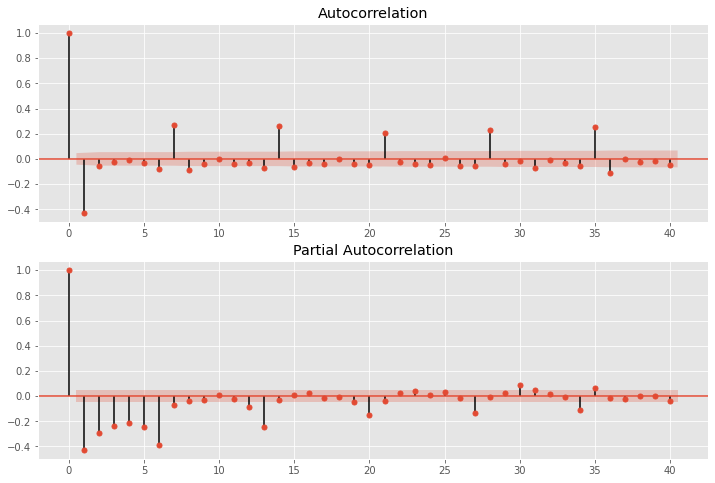

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont


**How to determin p, d, q**

It's easy to determin I. In our case, we see the first order differencing make the **ts stationary. I = 1.**

In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use **AR = 6 (6 lines are crossed the blue lines so 6past days are required to predict)**

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [ ]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Wed, 26 May 2021   AIC                          11211.335
Time:                        05:17:26   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

**Analyze the result**

To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.



NormaltestResult(statistic=16.426390730271244, pvalue=0.00027105322202365087)


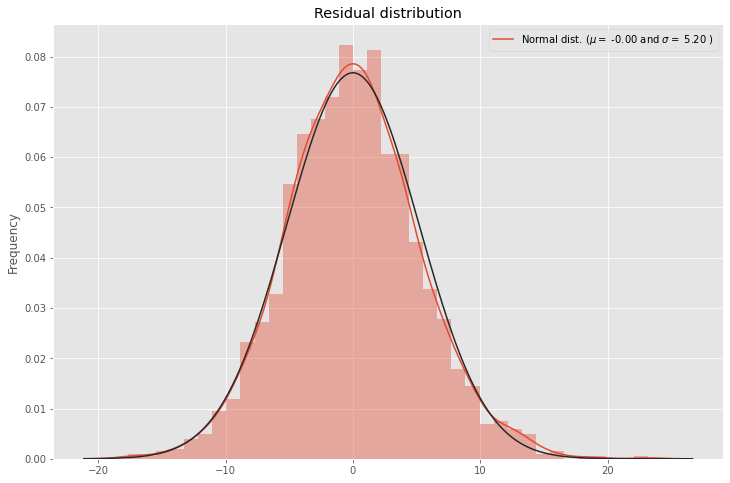

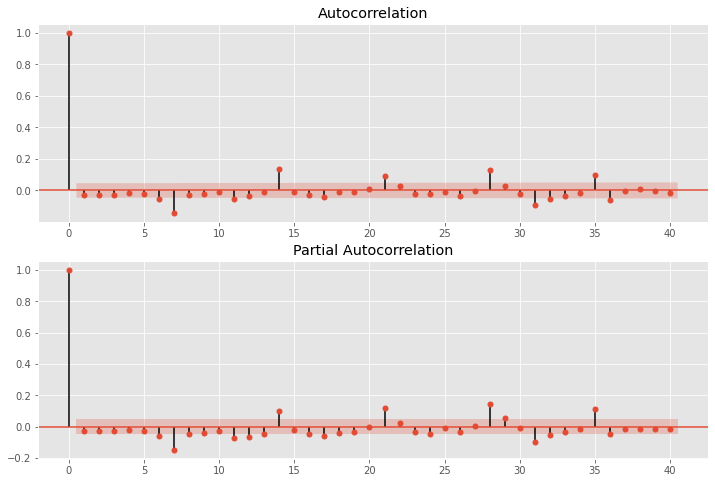

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

When the plots of ACF and PACF are similar or any sesaonality is present between them than we need to apply **SARIMA** model, which it is extended model of **ARIMA**

**What is SARIMA and what is the use of it ?**

ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting, but it does not support time series with a seasonal component. The ARIMA model is extended (SARIMA) to support the seasonal component of the series. SARIMA (Seasonal Autoregressive Integrated Moving Average), method for time series forecasting is used on univariate data containing trends and seasonality. SARIMA is composed of trend and seasonal elements of the series.

Some of the parameters that are same as ARIMA model are:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order
There are four seasonal elements that are not part of ARIMA are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
Thus SARIMA model can be specified as:
SARIMA (p, d, q) (P,D,Q) m

If m is 12, it specifies monthly data suggests a yearly seasonal cycle.
SARIMA time series models can also be combined with spatial and event based models to yield ensemble models that solves multi-dimensional ML problems. Such a ML model can be designed to predict cell load in cellular networks at different times of the day round the year as illustrated below in the sample figure
Autocorrelation, trend, and seasonality (weekday , weekend effects) from time series analysis can be used to interpret temporal influence.
Regional and cell wise load distribution can be used to predict sparse and over loaded cells in varying intervals of time.
Events (holidays, special mass gatherings and others) can be predicted using decision trees.

**Reference :**

https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a



In [ ]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 26 May 2021   AIC                          11209.359
Time:                        05:17:29   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

******

NormaltestResult(statistic=16.742690148319554, pvalue=0.00023140408865311604)


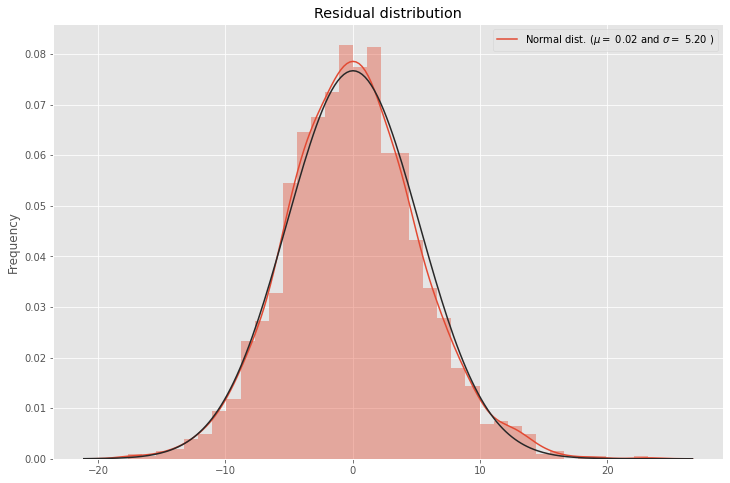

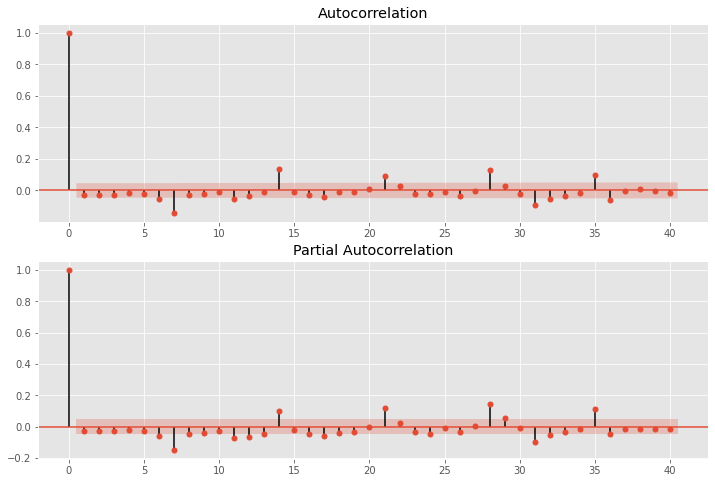

In [ ]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

**Make prediction and evaluation**

Take the last 30 days in training set as validation data



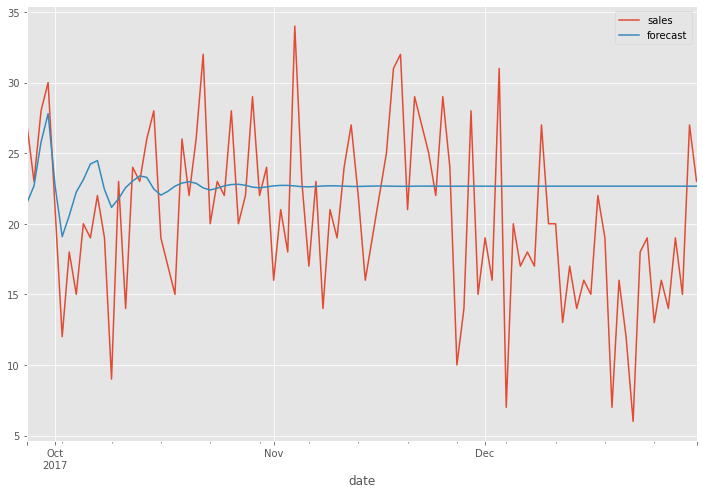

In [ ]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

**Evaluations of the model**

In [ ]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [ ]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


**Conclusion**

The study concludes with some case studies why specific machine learning methods perform so poorly in practice, given their impressive performance in other areas of artificial intelligence.
The challenge leaves it open to evaluate reasons of poor performance for ARIMA/SARIMA and LSTM models, and devise mechanisms to improve model’s poor performance and accuracy. Some of the areas of application of the models and their performance is listed below:

ARIMA yields better results in forecasting short term, whereas LSTM yields better results for long term modeling.
Traditional time series forecasting methods (ARIMA) focus on univariate data with linear relationships and fixed and manually-diagnosed temporal dependence.
Machine learning problems with substantial dataset, its found that the average reduction in error rates obtained by LSTM is between 84–87 percent when compared to ARIMA indicating the superiority of LSTM to ARIMA.

The number of training times, known as “epoch” in deep learning, has no effect on the performance of the trained forecast model and it exhibits a truly random behavior.

LSTMs when compared to simpler NNs like RNN and MLP appear to be more suited at fitting or overfitting the training dataset rather than forecasting it.

Neural networks (LSTMs and other deep learning methods) with huge datasets offer ways to divide it into several smaller batches and train the network in multiple stages. 
The batch size/each chunk size refers to the total number of training data used. The term iteration is used to represent number of batches needed to complete training a model using the entire dataset.

LSTM is undoubtedly more complicated and difficult to train and in most cases do not exceed the performance of a simple ARIMA model.





## part B

### SOURCING AND OUTSOURCING 


In [ ]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

lat1 = 40.5; lat2 = 42; long1 = -90; long2 = -93
print( distance((lat1, long1), (lat2, long2)) )


301.17000641409464


In [ ]:
!pip install calmap

In [ ]:
#Data Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import folium
import calmap
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_dark"

#Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

#displaying markdown
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

#Web scraping tools
#REQUESTS --> to fetch data from website
import requests
import json

#BEAUTIFULSOUP  -->parse HTML content 
from bs4 import BeautifulSoup  

#Showing full path of datasets
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas  as  pd 
import  numpy  as  np
import  seaborn  as  sns 
import  matplotlib.pyplot  as  plt 
%matplotlib inline
from  datetime  import  datetime 
from  time  import  time 
from  datetime  import  timedelta
import os
import itertools


In [ ]:
#os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dataset/available_products.csv')
df.head()

,Pune,Delhi
0,brakes,tyre
1,fuel_pump,brakes
2,tyre,v4


In [ ]:
part = input("enter a product name ")

enter a product name brakes


In [ ]:
def search(part):
    if part in df.values : 
        return df.columns
    else : 
        print("\nThis value does not exists in Dataframe") 

In [ ]:
a=search(part)
print(a)

Index(['Pune', 'Delhi'], dtype='object')


In [ ]:
def search(part):
    lst=[]
    for (columnName, columnData) in df.iteritems():
        if part in columnData.values : 
            lst.append(columnName)
    return(lst)

 

In [ ]:
a=search(part)
print(a)
print(part)

['Pune', 'Delhi']
brakes


In [ ]:
distance=pd.read_csv('/content/drive/My Drive/Dataset/district wise centroids.csv')
distance.head()

,State,District,Latitude,Longitude
0,Andaman and Nicobar,Andaman Islands,12.382571,92.822911
1,Andaman and Nicobar,Nicobar Islands,7.835291,93.511601
2,Andhra Pradesh,Adilabad,19.284514,78.813212
3,Andhra Pradesh,Anantapur,14.312066,77.460158
4,Andhra Pradesh,Chittoor,13.331093,78.927639


In [ ]:
distance['Longitude']

0      92.822911
1      93.511601
2      78.813212
3      77.460158
4      78.927639
         ...    
589    88.877940
590    86.396853
591    88.445370
592    88.235952
593    87.231014
Name: Longitude, Length: 594, dtype: float64

In [ ]:
distance[distance["District"]=='Pune'] 

,State,District,Latitude,Longitude
328,Maharashtra,Pune,18.516962,74.129229


In [ ]:
#distance.loc(distance[distance['District'] == location])

In [ ]:
e=pd.DataFrame()
latitudes=[]
longitudes=[]
locations=[]

In [ ]:
for i in range(len(a)):
    location=a[i]
    e=distance[distance['District'] == location]
    latitudes.append(list(e["Latitude"]))
    longitudes.append(list(e["Longitude"]))
    locations.append(list(e["District"]))
    
    
#c['Latitude']

In [ ]:
longitudes

[[74.12922881632646], [77.1280451754386]]

In [ ]:
latitudes


[[18.51696171428573], [28.64594429824561]]

In [ ]:
latitude = latitudes
  
# output list 
latitudes = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(latitude): 
    for i in latitude: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            latitudes.append(i) 
  
# Driver code 
print ('The original list: ', latitude) 
reemovNestings(latitude) 
print ('The list after removing nesting: ', latitudes) 

The original list:  [[18.51696171428573], [28.64594429824561]]
The list after removing nesting:  [18.51696171428573, 28.64594429824561]


In [ ]:
longitude = longitudes
  
# output list 
longitudes = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(longitude): 
    for i in longitude: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            longitudes.append(i) 
  
# Driver code 
print ('The original list: ', longitude) 
reemovNestings(longitude) 
print ('The list after removing nesting: ', longitudes) 

The original list:  [[74.12922881632646], [77.1280451754386]]
The list after removing nesting:  [74.12922881632646, 77.1280451754386]


In [ ]:
locations

[['Pune'], ['Delhi']]

In [ ]:
location = locations
  
# output list 
locations = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(location): 
    for i in location: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            locations.append(i) 
  
# Driver code 
print ('The original list: ', location) 
reemovNestings(location) 
print ('The list after removing nesting: ', locations) 

The original list:  [['Pune'], ['Delhi']]
The list after removing nesting:  ['Pune', 'Delhi']


In [ ]:
longitudes

[74.12922881632646, 77.1280451754386]

In [ ]:
latitudes

[18.51696171428573, 28.64594429824561]

In [ ]:

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    print(d)

    return d





sleepy=[]
j=0
lat1 = 27.1767; lat2 = 0; long1 = 78.0081; long2 = 0
for i in range(len(latitudes)):
        j=i
        lat2=float(latitudes[i])
        long2=float(longitudes[j])
        aa=distance((lat1, long1), (lat2, long2))
        sleepy.append(aa)
        

minpos = sleepy.index(min(sleepy))
print("closest_location_is",locations[minpos])

1041.502317603526
184.84472203899054
closest_location_is Delhi


In [ ]:
#Creating Empty Map
radius = 0

m=folium.Map(location=[20.5937, 78.9629], zoom_start=14,max_zoom=4,min_zoom=3,tiles="Stamen Toner",
            height = 600,width = '70%')

for i in range(0,len(latitudes)):
    folium.Circle(location=[latitudes[i],longitudes[i]],
                 color="crimson",
                 radius=int(1000*50),
                  tooltip='<li><bold>District: '+str(locations[i])+
                  '<li><bold>Available part : '+str(part),
                  fill=True
                 ).add_to(m)

folium.Marker(location=[12.9716,77.5946],tooltip='<li><bold>WAREHOUSE LOCATION: '+str('BANGLORE'),icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)

#for i in range(0,len(latitudes)):
#    folium.Marker(location=[latitudes[i],longitudes[i]],
#                  icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)
                 
m

In [ ]:
m = folium.Map(location=[28,77], zoom_start=4)

# I can add marker one by one on the map
for i in range(0,len(latitudes)):
    folium.Circle(location=[latitudes[i],longitudes[i]],
                 color="crimson",
                  radius=int(1000*50),
                  tooltip='<li><bold>District: '+str(locations[i])+
                  '<li><bold>Available part : '+str(part),
                  fill=True, fill_color='crimson'
                 ).add_to(m)
    
folium.Marker(location=[12.9716,77.5946],
              tooltip='<li><bold>WAREHOUSE LOCATION: '+str('BANGLORE'),
              icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)

m

In [ ]:
help(folium.Icon)

Help on class Icon in module folium.map:

class Icon(branca.element.MacroElement)
 |  Icon(color='blue', icon_color='white', icon='info-sign', angle=0, prefix='glyphicon')
 |  
 |  Creates an Icon object that will be rendered
 |  using Leaflet.awesome-markers.
 |  
 |  Parameters
 |  ----------
 |  color : str, default 'blue'
 |      The color of the marker. You can use:
 |  
 |          ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
 |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
 |           'gray', 'black', 'lightgray']
 |  
 |  icon_color : str, default 'white'
 |      The color of the drawing on the marker. You can use colors above,
 |      or an html color code.
 |  icon : str, default 'info-sign'
 |      The name of the marker sign.
 |      See Font-Awesome website to choose yours.
 |      Warning : depending on the icon you choose you may need to adapt
 |      the `prefix` as

## Considering constant speed for now i.e 40km/hr

In [ ]:
speed=40
for i in range(len(sleepy)):
    time_taken=sleepy[i]/speed
    print("time to deliver from",locations[i],"is",int(time_taken),"HOURS")

time to deliver from Pune is 26 HOURS
time to deliver from Delhi is 4 HOURS


## Now lets predict the trip duration using Machine Learning Techniques

# Trip Duration Prediction
**The purpose of this modelling is to accurately predict the trip duration of taxi's. To make predictions we will use several algorithms, tune the corresponding parameters of the algorithm by analysisng each parameter against RMSE and predict the trip duration. To make our prediction we use RandomForest Regressor, LinearSVR and LinearRegression.**

## How does the pipeline look
**1. Loading the data**
**2. Cleaning the data**
**3. Training the model**
**4. Making Predictions**
**5. Tuning the hyper Parameters to increase Confidence**

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.cluster import KMeans
from matplotlib import style
import pickle
style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
#os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
#path = "random_2015_cleaned.csv"
#'/content/drive/My Drive/Tranferlearning-indian currency/dataset/xxxfile'
df = pd.read_csv('/content/drive/My Drive/Dataset/random_2015_cleaned.csv')
df.dropna(inplace=True)
df.head(10)

,Unnamed: 0,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,pickup_hrs,dropoff_hrs,day_week,tpep_pickup_timestamp,tpep_dropoff_timestamp,duration,speed
0,0,2015-01-24 18:00:28,2015-01-24 18:10:07,-73.964111,40.761398,-73.977989,40.783093,2.40,18,18,5,1422122428,1422123007,579,14
1,1,2015-01-15 4:37:29,2015-01-15 4:58:14,-73.961479,40.760410,-73.943573,40.709702,5.00,4,4,3,1421296649,1421297894,1245,14
2,2,2015-01-09 5:14:31,2015-01-09 5:47:16,-73.986893,40.761726,-73.873169,40.774326,10.25,5,5,4,1420780471,1420782436,1965,18
3,3,2015-01-29 9:52:05,2015-01-29 10:16:33,-73.965759,40.758114,-74.010399,40.701965,5.46,9,10,3,1422525125,1422526593,1468,13
4,4,2015-01-02 2:20:01,2015-01-02 2:27:37,-73.955032,40.821857,-73.950897,40.808399,1.50,2,2,4,1420165201,1420165657,456,11
5,5,2015-01-01 19:14:46,2015-01-01 19:20:40,-73.994591,40.718838,-73.986519,40.734516,1.17,19,19,3,1420139686,1420140040,354,11
6,6,2015-01-31 9:33:42,2015-01-31 9:52:08,-73.994942,40.760181,-73.990631,40.726719,3.15,9,9,5,1422696822,1422697928,1106,10
7,7,2015-01-08 18:18:30,2015-01-08 18:23:16,-74.004387,40.747833,-73.999710,40.761620,1.22,18,18,3,1420741110,1420741396,286,15
8,8,2015-01-15 13:33:52,2015-01-15 13:50:40,-73.954140,40.787304,-73.962906,40.762283,2.30,13,13,3,1421328832,1421329840,1008,8
9,9,2015-01-09 7:01:13,2015-01-09 7:07:42,-73.997215,40.684391,-73.990883,40.692833,0.80,7,7,4,1420786873,1420787262,389,7


In [ ]:
#Getting attributes for EDA
df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['pickup_hrs'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hrs'] = df['tpep_dropoff_datetime'].dt.hour
df['day_week'] = df['tpep_pickup_datetime'].dt.weekday
df['tpep_pickup_timestamp'] = (df['tpep_pickup_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds()
df['tpep_dropoff_timestamp'] = (df['tpep_dropoff_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds() 
df['duration'] = df['tpep_dropoff_timestamp'] - df['tpep_pickup_timestamp']
df['speed'] = (df['trip_distance'] * 3600)//df['duration']

In [ ]:
#cleaning for EDA, removing outliers
df = df[ (df['duration'] > 0)]
df = df[ (df['speed'] > 6.0)]
df = df[ (df['speed'] < 140.0)]
df = df[ (df['pickup_longitude'] != 0)]
df = df[ (df['dropoff_longitude'] != 0)]
df = df[ (df['pickup_latitude'] > 38)]
df = df[ (df['pickup_latitude'] < 45)]


In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,pickup_hrs,dropoff_hrs,day_week,tpep_pickup_timestamp,tpep_dropoff_timestamp,duration,speed
0,2015-01-24 18:00:28,2015-01-24 18:10:07,-73.964111,40.761398,-73.977989,40.783093,2.40,18,18,5,1.422122e+09,1.422123e+09,579.0,14.0
1,2015-01-15 04:37:29,2015-01-15 04:58:14,-73.961479,40.760410,-73.943573,40.709702,5.00,4,4,3,1.421297e+09,1.421298e+09,1245.0,14.0
2,2015-01-09 05:14:31,2015-01-09 05:47:16,-73.986893,40.761726,-73.873169,40.774326,10.25,5,5,4,1.420780e+09,1.420782e+09,1965.0,18.0
3,2015-01-29 09:52:05,2015-01-29 10:16:33,-73.965759,40.758114,-74.010399,40.701965,5.46,9,10,3,1.422525e+09,1.422527e+09,1468.0,13.0
4,2015-01-02 02:20:01,2015-01-02 02:27:37,-73.955032,40.821857,-73.950897,40.808399,1.50,2,2,4,1.420165e+09,1.420166e+09,456.0,11.0


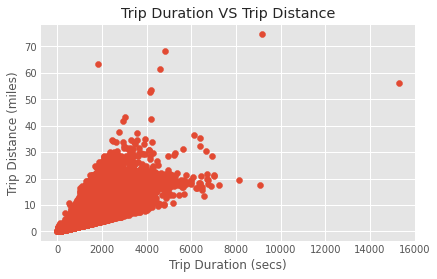

In [ ]:
#EDA
plt.scatter(df['duration'], df['trip_distance'])
plt.title('Trip Duration VS Trip Distance')
plt.xlabel('Trip Duration (secs)')
plt.ylabel('Trip Distance (miles)')
plt.show()

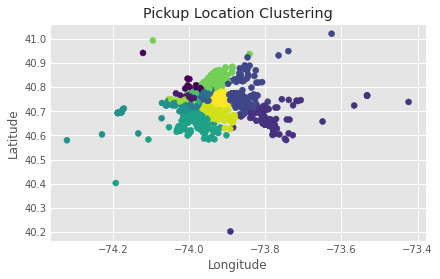

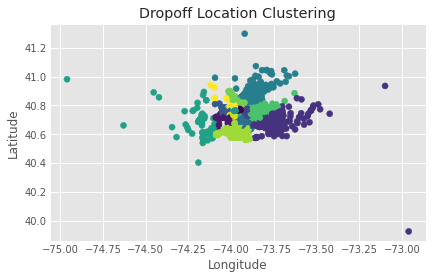

In [ ]:
#clustering pickup and dropoff locations
n = len(df)
kmeans_pickup = KMeans(n_clusters = 15, random_state = 2).fit(df[['pickup_latitude', 'pickup_longitude']])
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
plt.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

kmeans_dropoff = KMeans(n_clusters = 15, random_state = 2).fit(df[['dropoff_latitude', 'dropoff_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])
plt.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
#creating dummy variables/one hot encoding, adding features
df = pd.concat([df, pd.get_dummies(df['pickup_hrs'], prefix = 'hrs')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['day_week'], prefix = 'day')], axis = 1)
df['pickup_dropoff_cluster'] = df['kmeans_pickup'].map(str) + 'to' +  df['kmeans_dropoff'].map(str)
df = pd.concat([df, pd.get_dummies(df['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)

In [ ]:
##cleaninig df for training containig only features
df.drop(df.columns[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 47]], axis = 1, inplace = True)

In [ ]:
#writing cleaned data to file for post prediction analysis and tuning hyperparameyres for Randomforest
df.to_csv('post_analysis_data.csv')

# MODELS

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(df.drop(['duration'], 1))
y = np.array(df['duration'])

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#Scaler = MinMaxScaler(feature_range = (0,1))
#X = Scaler.fit_transform(X)
#X = pd.DataFrame(X)
#print(X.head(5))
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X= sc.fit_transform(X)
#X = sc.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import *

## a) Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)



In [ ]:
accuracy = lr.score(X_test, y_test)
accuracy

0.7805781859765831

In [ ]:
predictions = lr.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error : 170.7867109199458


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

Root Mean Squared Error is  259.4134724830809


In [ ]:
y_pred = lr.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

rscore is 0.7805781859765831


## b) Support vector regression (SVRs)

In [ ]:
from sklearn import svm
svm = svm.SVR()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


In [ ]:
accuracy = svm.score(X_test, y_test)
accuracy

In [ ]:
predictions = svm.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

In [ ]:
y_pred = svm.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

## c) Bayesian regression 

In [ ]:
from sklearn.linear_model import BayesianRidge
# Creating and training model
modelb = BayesianRidge()
modelb.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [ ]:
accuracy = modelb.score(X_test, y_test)
accuracy

0.780553392432325

In [ ]:
predictions = modelb.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error : 170.94139274017988


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

Root Mean Squared Error is  259.42812826778606


In [ ]:
y_pred = modelb.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

rscore is 0.780553392432325


## d) Decision Tree Regression

In [ ]:
#from sklearn import tree
#d3 = tree.DecisionTreeClassifier()
##d3.fit(X_train,y_train)
#d3_pred=d3.predict(X_test)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
d3= DecisionTreeRegressor()
d3.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
accuracy = d3.score(X_test, y_test)
accuracy

0.7072930124263475

In [ ]:
predictions = d3.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error : 179.71852584942945


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

Root Mean Squared Error is  299.6188768169315


In [ ]:
y_pred = d3.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

rscore is 0.7072930124263475


## e) KNN regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
knn_pred=neigh.predict(X_test)

In [ ]:
accuracy = neigh.score(X_test, y_test)
accuracy

0.7509285383054066

In [ ]:
predictions = neigh.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error : 168.74404283801874


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

Root Mean Squared Error is  276.385090392524


In [ ]:
y_pred = neigh.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

rscore is 0.7509285383054066


## F) Random forest Regressor

In [ ]:
## Training the model

In [ ]:
clf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
##Making Predictions

In [ ]:
accuracy = clf.score(X_test, y_test)


In [ ]:
accuracy

0.8264000477212416

In [ ]:
predictions = clf.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error : 142.01376535875664


In [ ]:
print("Root Mean Squared Error is ", mean_squared_error(y_test,predictions)**(0.5))

Root Mean Squared Error is  230.74241157859484


In [ ]:
y_pred = clf.predict(X_test)
print("rscore is",sklearn.metrics.r2_score(y_test,y_pred))

rscore is 0.8264000477212416


In [ ]:
#Tuning/Analysing the hyperparameters to improve confidence

In [ ]:
#Analysing the required number of trees for RandomForest
a = np.array([[10, 247]])
for i in range(20, 60, 10):
    clf = RandomForestRegressor(n_estimators = i)
    clf.fit(X_train, y_train)
    y_actual = y_test
    y_pred = clf.predict(X_test)
    rms = sqrt(mean_squared_error(y_actual, y_pred))
    a = np.append(a, [[i, rms]], axis = 0)
    
plt.plot(a[:, 0], a[:, 1], linewidth = 2.0)
plt.title('RMSE VS No. of Trees')
plt.xlabel('No. of Trees')
plt.ylabel('RMSE')
plt.show()

## PART C) Invoice Data Analysis 

In [ ]:
import pandas as pd
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import os
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20,.2f}'.format

In [ ]:
DataSet = pd.read_csv('/content/drive/MyDrive/Dataset/invoice.csv').fillna(0)

In [ ]:
TotalRowCount = len(DataSet)
print("Total Number of Data Count :", TotalRowCount)

Total Number of Data Count : 49


***Invoice Contents Simplified***

In [ ]:
DataSet.dtypes

InvoiceID                       int64
ProductID                      object
City                           object
Fulfill Via                    object
Shipment Mode                  object
PO Sent to Vendor Date         object
Scheduled Delivery Date        object
Delivered to Client Date       object
Delivery Recorded Date         object
Vendor                         object
Item Description               object
Brand                          object
Unit of Measure (Per Pack)      int64
Line Item Quantity              int64
Line Item Value               float64
Pack Price                    float64
Unit Price                    float64
Manufacturing Site             object
Payment Status                 object
Weight (Kilograms)            float64
Freight Cost (Rupees)         float64
dtype: object

In [ ]:
DataSet.head(10)

,InvoiceID,ProductID,City,Fulfill Via,Shipment Mode,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Vendor,Item Description,Brand,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,Payment Status,Weight (Kilograms),Freight Cost (Rupees)
0,1,100-CI-T01,Mumbai,Direct Drop,Air,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,R Fine LTD,brakes,Reveal,30,19,551.00,29.00,0.97,R Fine LTD,processing,13.00,780.34
1,3,108-VN-T01,Delhi,Direct Drop,Air,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,"Aurobindo Unit III, India",brakes,Generic,240,1000,"6,200.00",6.20,0.03,"Aurobindo Unit III, India",done,358.00,"4,521.50"
2,4,100-CI-T01,Kolkata,Direct Drop,Air,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,ABBVIE GmbH & Co.KG Wiesbaden,brakes,Determine,100,500,"40,000.00",80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,processing,171.00,"1,653.78"
3,15,108-VN-T01,Bangalore,Direct Drop,Air,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,R Fine LTD,brakes,Generic,60,31920,"127,360.80",3.99,0.07,R Fine LTD,processing,"1,855.00","16,007.06"
4,16,108-VN-T01,Mumbai,Direct Drop,Air,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,"Aurobindo Unit III, India",brakes,Generic,60,38000,"121,600.00",3.20,0.05,"Aurobindo Unit III, India",processing,"7,590.00","45,450.08"
5,23,112-NG-T01,Delhi,Direct Drop,Truck,Date Not Captured,28-Sep-06,28-Sep-06,28-Sep-06,ABBVIE GmbH & Co.KG Wiesbaden,engine,Generic,240,416,"2,225.60",5.35,0.02,ABBVIE GmbH & Co.KG Wiesbaden,done,504.00,"5,920.42"
6,44,110-ZM-T01,Kolkata,Direct Drop,Air,Date Not Captured,8-Jan-07,8-Jan-07,8-Jan-07,R Fine LTD,engine,Stocrin/Sustiva,90,135,"4,374.00",32.40,0.36,R Fine LTD,done,328.00,"28,672.81"
7,45,109-TZ-T01,Bangalore,Direct Drop,Air,Date Not Captured,24-Nov-06,24-Nov-06,24-Nov-06,"Aurobindo Unit III, India",engine,Generic,60,16667,"60,834.55",3.65,0.06,"Aurobindo Unit III, India",processing,"1,478.00","33,325.36"
8,46,112-NG-T01,Mumbai,Direct Drop,Air,Date Not Captured,7-Dec-06,7-Dec-06,7-Dec-06,ABBVIE GmbH & Co.KG Wiesbaden,engine,Generic,60,273,532.35,1.95,0.03,ABBVIE GmbH & Co.KG Wiesbaden,done,"2,439.21","37,977.92"
9,47,110-ZM-T01,Delhi,Direct Drop,Ship,11/13/06,30-Jan-07,30-Jan-07,30-Jan-07,R Fine LTD,engine,Aluvia,120,2800,"115,080.00",41.10,0.34,R Fine LTD,processing,"2,639.68","42,630.47"


In [ ]:
DataSet.tail(10)

,InvoiceID,ProductID,City,Fulfill Via,Shipment Mode,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Vendor,Item Description,Brand,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,Payment Status,Weight (Kilograms),Freight Cost (Rupees)
39,392,104-CI-T01,Bangalore,Direct Drop,Air,3/3/08,19-Mar-09,19-Mar-09,19-Mar-09,"Aurobindo Unit III, India",tyres,Bioline,25,659,"13,180.00",20.00,0.80,"Aurobindo Unit III, India",processing,"8,653.61","182,207.12"
40,398,102-GY-T01,Mumbai,Direct Drop,Air,2/28/08,9-Apr-08,1-Apr-08,1-Apr-08,ABBVIE GmbH & Co.KG Wiesbaden,tyres,Generic,100,240,2.40,0.01,0.00,ABBVIE GmbH & Co.KG Wiesbaden,done,"8,854.07","186,859.67"
41,399,102-GY-T01,Delhi,Direct Drop,Air,2/28/08,28-Jul-08,28-Jul-08,28-Jul-08,R Fine LTD,tyres,Generic,100,213,2.13,0.01,0.00,R Fine LTD,done,"9,054.54","191,512.23"
42,400,117-ET-T01,Kolkata,Direct Drop,Air,2/29/08,11-Mar-08,11-Mar-08,11-Mar-08,"Aurobindo Unit III, India",tyres,Capillus,100,63,"13,399.25",212.69,2.13,"Aurobindo Unit III, India",processing,"9,255.00","196,164.78"
43,410,113-ZW-T01,Bangalore,Direct Drop,Air,3/17/08,17-Nov-08,17-Nov-08,17-Nov-08,ABBVIE GmbH & Co.KG Wiesbaden,tyres,Determine,100,1634,"117,631.66",71.99,0.72,ABBVIE GmbH & Co.KG Wiesbaden,done,"9,455.46","200,817.33"
44,411,123-NG-T01,Mumbai,Direct Drop,Truck,3/13/08,17-Apr-08,17-Apr-08,17-Apr-08,R Fine LTD,brakes,Stat-Pak,20,1425,"38,475.00",27.00,1.35,R Fine LTD,processing,"9,655.93","205,469.89"
45,414,119-NA-T01,Delhi,Direct Drop,Air,3/18/08,4-Jun-08,4-Jun-08,4-Jun-08,"Ci, India",engine,Determine,100,142,"10,222.58",71.99,0.72,"Ci, India",processing,"9,856.39","210,122.44"
46,420,108-VN-T01,Kolkata,Direct Drop,Air,3/31/08,3-Jun-08,3-Jun-08,3-Jun-08,ABBVIE GmbH & Co.KG Wiesbaden,lights,Generic,30,8400,"96,432.00",11.48,0.38,ABBVIE GmbH & Co.KG Wiesbaden,processing,"10,056.86","214,775.00"
47,422,116-ZA-T01,Bangalore,Direct Drop,Air,2/20/08,24-Apr-08,24-Apr-08,24-Apr-08,"BMS Meymac, France",tyres,Invirase,270,6,405.06,67.51,0.25,"BMS Meymac, France",done,"10,257.32","219,427.55"
48,423,116-ZA-T01,Mumbai,Direct Drop,Ship,2/20/08,24-Apr-08,24-Apr-08,24-Apr-08,R Fine LTD,brakes,Zerit,200,600,870.00,1.45,0.01,R Fine LTD,done,"10,457.79","224,080.11"


### ***Number of Transactions Per City**

City Wise Count 

Mumbai       13
Kolkata      12
Bangalore    12
Delhi        12
Name: City, dtype: int64


Text(0.5, 0, 'City Name')

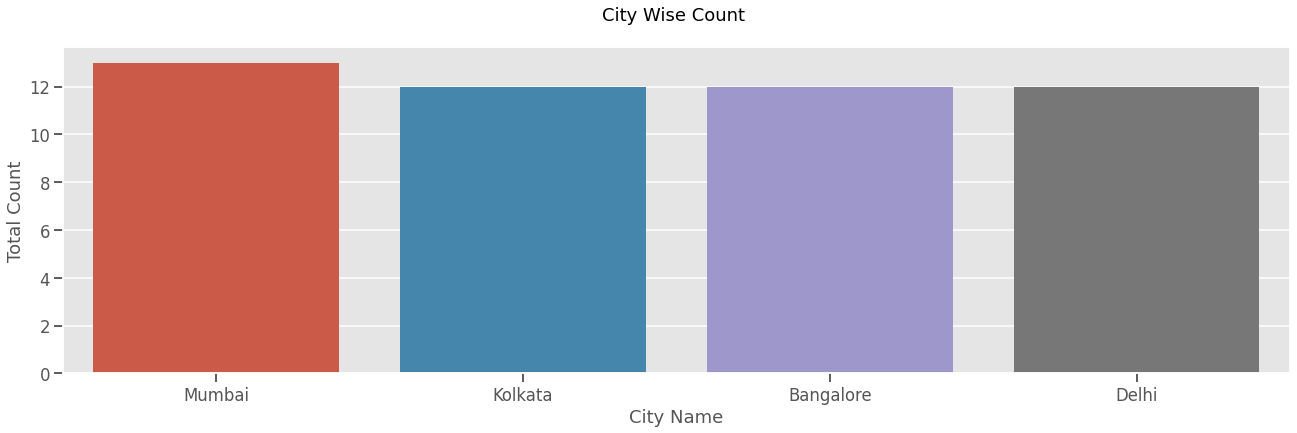

In [ ]:
DataSet = DataSet.dropna()
ItemCount = DataSet["City"].value_counts().nlargest(10)
print("City Wise Count \n")
print(ItemCount)
sn.set_context("talk",font_scale=1)
plt.figure(figsize=(22,6))
sn.countplot(DataSet['City'],order = DataSet['City'].value_counts().nlargest(10).index)
plt.title('City Wise Count \n')
plt.ylabel('Total Count')
plt.xlabel('City Name')

### ***Freight Cost City wise***

No handles with labels found to put in legend.


Text(0.5, 1.0, 'City Wise Freight Cost Comparision')

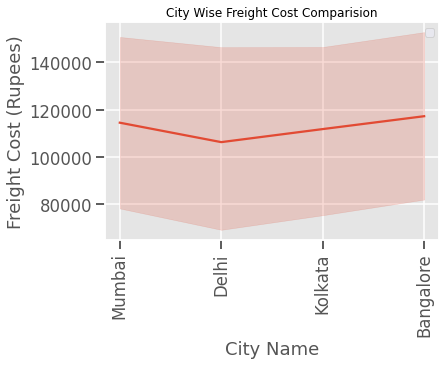

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/invoice.csv")
dataset = df
from matplotlib import style
import seaborn as sns

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')
#sns.lineplot(DataSet['City'],order = DataSet['City'].value_counts().nlargest(10).index)
sns.lineplot(x=dataset["City"], y=dataset["Freight Cost (Rupees)"], data=df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("City Wise Count ")
plt.xlabel("City Name")
plt.ylabel("Freight Cost (Rupees)")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("City Wise Freight Cost Comparision")

Total Pack Price for City 

City
Delhi                     675.56
Kolkata                   595.19
Bangalore                 422.78
Mumbai                    365.30
Name: Pack Price, dtype: float64


Text(0.5, 0, 'City Name')

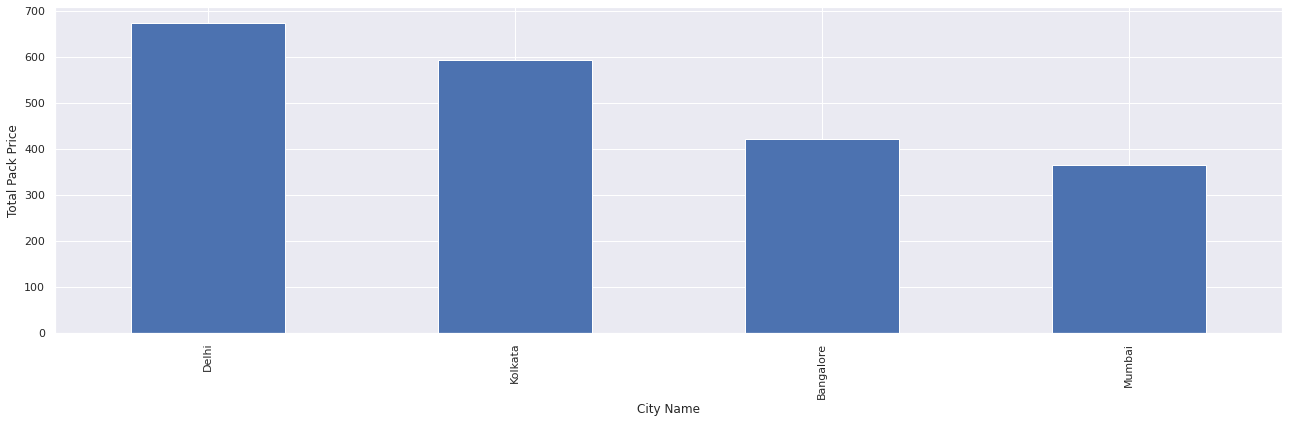

In [ ]:
TotalPrice = DataSet.groupby(['City'])['Pack Price'].sum().nlargest(15)
print("Total Pack Price for City \n")
print(TotalPrice)
plt.figure(figsize=(22,6))
GraphData=DataSet.groupby(['City'])['Pack Price'].sum().nlargest(15)
GraphData.plot(kind='bar')
plt.ylabel('Total Pack Price')
plt.xlabel('City Name')

###  *Total Payment Status*




Text(0.5, 0, 'Payment Status')

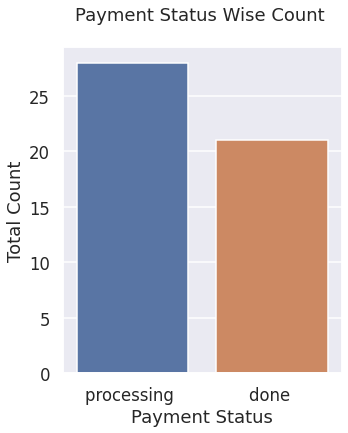

In [ ]:
sn.set_context("talk",font_scale=1)
plt.figure(figsize=(5,6))
sn.countplot(DataSet['Payment Status'],order = DataSet['Payment Status'].value_counts().nlargest(10).index)
plt.title('Payment Status Wise Count \n')
plt.ylabel('Total Count')
plt.xlabel('Payment Status')

In [ ]:
ShippingMode = DataSet["Shipment Mode"].value_counts()
labels = (np.array(ShippingMode.index))
sizes = (np.array((ShippingMode / ShippingMode.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title="Shipment Mode")
dat = [trace]
fig = go.Figure(data=dat, layout=layout)
py.iplot(fig, filename="Shipment Mode")
print("done")

done
